In [2]:
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from pprint import pprint
from tqdm import tqdm

In [3]:
LABEL_INT_DICT = np.unique(pd.read_csv('ucf11_train_vid.csv')['label'])
pprint(LABEL_INT_DICT)
LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [4]:
import albumentations as A
import cv2
import math
import tensorflow as tf
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, mode='train', shuffle=True):
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
            ])
            
        self.img_paths = glob(
            f'UCF11_updated_png/{mode}/*.png'
        )
        
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.img_paths[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for img_path in data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                augmented = self.transform(image=img)
                img = augmented['image']
            
            img = img.astype('float32')
            img = img / 255.
            
            label = img_path.split('\\')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]
            
            batch_x.append(img)
            batch_y.append(label)
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)

In [5]:
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    image_size=256,
    shuffle=True
)

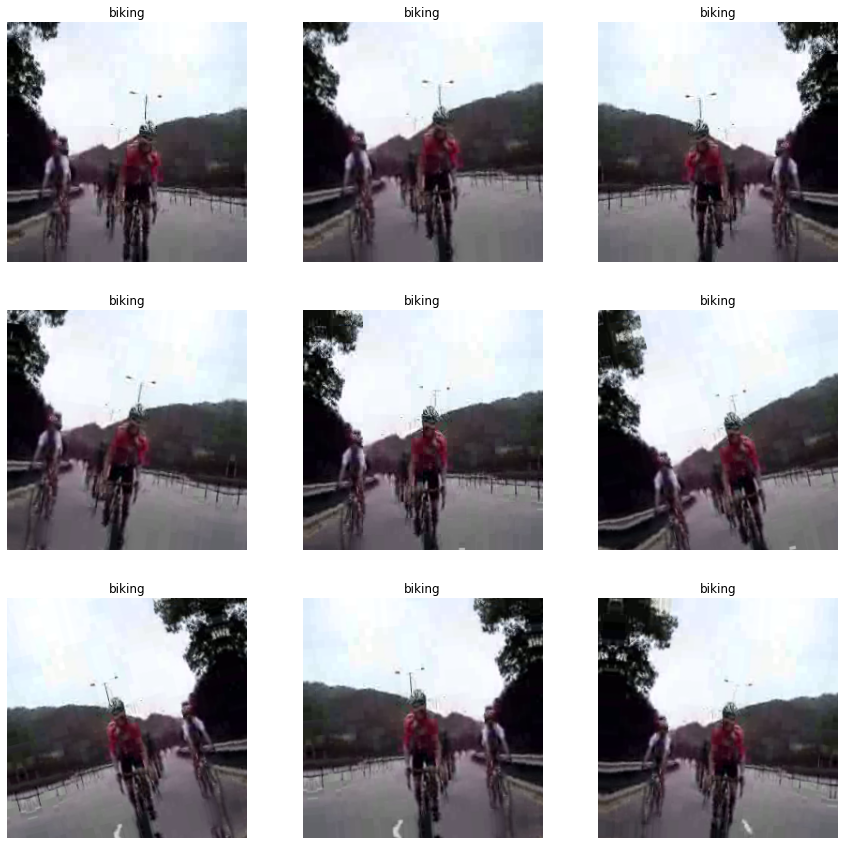

In [6]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')
    break

In [7]:
# tensorflow hub
# https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2',
                  trainable=True),
    tf.keras.layers.Dense(len(LABEL_INT_DICT), activation='softmax')
])
model.build([None, 256, 256, 3])

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 5,933,403
Trainable params: 5,872,795
Non-trainable params: 60,608
_________________________________________________________________


f:\python\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
import os

os.mkdir('ucf11_weights')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'ucf11_weights'

In [12]:
filepath = 'ucf11_weights/{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint =tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor = 'val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    verbose=1,
    callbacks=[
        model_checkpoint
    ]
)

Epoch 1/10


In [15]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.lengend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Accuracy')
plt.show()

NameError: name 'history' is not defined

In [17]:
csv_path = 'ucf11_valid_vid.csv'
valid_df = pd.read_csv(csv_path)

value = 0
for i, elem in tqdm(valid_df.iterrows(), total=len(valid_df)):
    cap =cv2.VideoCapture(
        elem['file_path']
    )
    
    preds = []
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))
        frame = frame.astype('float32')
        frame /= 255.
        
        pred = model.predict(frame[np.newaxis, ...])
        preds.append(pred)
        
    preds = np.array(preds).mean(axis=0)
    label = LABEL_INT_DICT[np.argmax(preds)]
    
    if label == elem['label']:
        value += 1
        
    cap.release()
    
print('Accuracy : ', value / len(valid_df))

  7%|██████                                                                             | 4/55 [03:04<39:11, 46.12s/it]


KeyboardInterrupt: 